In [39]:
# imported from tripadvisor_search
import sys
import csv
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.by import By
import time
import re
import pandas as pd

# imported from twitter_scraper
import datetime
from bs4 import BeautifulSoup
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.support.wait import WebDriverWait
import pandas as pd
from selenium.webdriver import ChromeOptions

# imported from tripadvisor_reviews_scraper
from selenium.webdriver.remote.webelement import WebElement
import re

# imported from get_analysis
import random
from collections import Counter
from googletrans import Translator
import string
import nltk

from nltk.corpus import stopwords
stopwords = set(stopwords.words('english'))

from gensim.parsing.preprocessing import strip_punctuation, strip_numeric,\
                    strip_non_alphanum, strip_multiple_whitespaces, strip_short

from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()
from textblob import TextBlob
import matplotlib.pyplot as plt

In [ ]:
# execute if not installed
# pip install -U textblob
# pip install googletrans==3.1.0a0 
# pip install gensim
# nltk.download('stopwords')
# nltk.download('omw-1.4')
# nltk.download('wordnet')

In [92]:
def get_top_from_query(query, max_elements=10):
    options = webdriver.ChromeOptions()
    options.add_argument('-headless')
    options.add_argument('-no-sandbox')
    options.add_argument('-disable-dev-shm-usage')
    options.add_argument("enable-automation")
    options.add_argument("--window-size=1920,1080")
    options.add_argument("--disable-extensions")
    options.add_argument("--dns-prefetch-disable")
    options.add_argument("--disable-gpu")
    driver = webdriver.Chrome('chromedriver', options = options)
    
    root = "https://www.tripadvisor.com/"

    url = root + 'Search?q=' + query + " restaurants"
    url = url.replace(' ', '%20')
    driver.get(url)
    html = driver.page_source
    print('Scraping information from this address: ', driver.current_url)
    
    rest_list = driver.find_elements(By.XPATH, "//div[@data-test-target='restaurants-list']/div")
    idx = 0
    df = pd.DataFrame(columns = ['name', 'link'])
    for rest in rest_list:
        if(len(rest.get_attribute("class")) > 0):
            continue
        link = rest.find_element(By.TAG_NAME, "a").get_attribute("href")
        match = re.search(r'Reviews-(.+?).html', link)
        name = match.group(1)
        name = name.replace('_', ' ').replace('-', ' ')
        words = name.split()
        name = (" ".join(sorted(set(words), key=words.index))) # remove duplicates
        df = df.append({'name':name,'link':link}, ignore_index=True)

        if(idx >= max_elements-1):
            break
        idx += 1
        
    return df

In [11]:
def twitter_scraper(query, Stop_num, kw_start_point=0, start_date=None, end_date=None):
    
    options = webdriver.ChromeOptions()
    options.add_argument('-headless')
    options.add_argument('-no-sandbox')
    options.add_argument('-disable-dev-shm-usage')
    options.add_argument("enable-automation")
    options.add_argument("--window-size=1920,1080")
    options.add_argument("--disable-extensions")
    options.add_argument("--dns-prefetch-disable")
    options.add_argument("--disable-gpu")
    page_index = 1
    search_end = False
    
    Data_List = []
    History_data = []
    
    driver = webdriver.Chrome('chromedriver', options = options)
    url = 'https://twitter.com/search?q=%s&src=typed_query&f=live' % query
    driver.get(url)
    driver.implicitly_wait(10)

    try:
        old_scroll_height = 0  # page in the top
        js1 = 'return document.body.scrollHeight'  # get the height of page
        js2 = 'window.scrollTo(0, document.body.scrollHeight)'  # scroll the page
        while ((driver.execute_script(js1) > old_scroll_height and len(
                Data_List) < Stop_num) and search_end == False):  # compare the height with previous page
            
            old_scroll_height = driver.execute_script(js1)  # get height of page
            driver.execute_script(js2)  # scroll page
            time.sleep(3)  # timesleep
            html = driver.page_source
            soup = BeautifulSoup(html, 'html.parser')
            divs = soup.find_all('div', {'class': 'css-1dbjc4n r-1iusvr4 r-16y2uox r-1777fci r-kzbkwu'})

            for divIndex, div in enumerate(divs):
                data_list = []
                try:
                    content = div.find('div', {
                        'class': 'css-901oao r-18jsvk2 r-37j5jr r-a023e6 r-16dba41 r-rjixqe r-bcqeeo r-bnwqim r-qvutc0'})
                    if (content):
                        str_content = content.get_text()
                    else:
                        content = div.find('div', {
                            'class': 'css-901oao r-18jsvk2 r-1tl8opc r-a023e6 r-16dba41 r-rjixqe r-bcqeeo r-bnwqim r-qvutc0'})
                        str_content = content.get_text()
                    if (('https://instagram.com' in str_content) and ('oto ' in str_content)):
                        pass
                    
                    # time
                    date = div.find('time')
                    date = date['datetime']
                    date = date.split('T')[0]
                    
                   #timeline
                    if (date > start_date):
                        continue
                    if (date < end_date):
                       search_end = True

                    # dataSet
                    if (str_content not in History_data):
                        data_list.append(date)
                        data_list.append(str(str_content).strip().replace('\n', ''))  # content
                        History_data.append(str_content)
                    else:
                        continue
                        
                except:
                    continue
                    
                Data_List.append(data_list)

    except Exception as e:
        print(e)
        
    df_sheet = pd.DataFrame(Data_List, columns=['Date', 'Content'])
    driver.close()
    return df_sheet

In [86]:
def get_reviews_from_url(url):
    
    options = webdriver.ChromeOptions()
    options.add_argument('-headless')
    options.add_argument('-no-sandbox')
    options.add_argument('-disable-dev-shm-usage')
    options.add_argument("enable-automation")
    options.add_argument("--window-size=1920,1080")
    options.add_argument("--disable-extensions")
    options.add_argument("--dns-prefetch-disable")
    options.add_argument("--disable-gpu")
    driver = webdriver.Chrome('chromedriver', options = options)
    driver.get(url)
    
    num_page = 15 # max number of pages to scrape
    df = pd.DataFrame(columns=['title', 'date', 'rating', 'review'])
    
    for i in range(0, num_page):
    
        time.sleep(2)
        try:
            element = driver.find_element(By.XPATH, "//span[@class='taLnk ulBlueLinks']") # expand the review 
            driver.execute_script("arguments[0].click();", element)
        except:
            pass
        time.sleep(2)

        container = driver.find_elements(By.XPATH, ".//div[@class='review-container']")

        for j in range(len(container)):

            title = container[j].find_element(By.XPATH, ".//span[@class='noQuotes']").text
            date = container[j].find_element(By.XPATH, ".//span[contains(@class, 'ratingDate')]").get_attribute("title")
            rating = container[j].find_element(By.XPATH, ".//span[contains(@class, 'ui_bubble_rating bubble_')]").get_attribute("class").split("_")[3]
            review = container[j].find_element(By.XPATH, ".//p[@class='partial_entry']").text.replace("\n", " ")
        
            row = {'title':title, 'date':date, 'rating':rating, 'review':review}
            df = df.append(row, ignore_index=True)

        try:
            if (driver.find_elements(By.XPATH, ".//a[@class='nav next ui_button primary disabled']")):
                break # if there are no pages left, constraint: pages <= num_pages

            # change the page
            next = driver.find_element(By.XPATH, './/a[@class="nav next ui_button primary"]')
            driver.execute_script("arguments[0].click();", next)
            time.sleep(2)
        except:
            break
        
    driver.close()
    return df

In [54]:
def clean_text(text, name):

    text = text.lower()
    text = re.sub(r'http\S+', '', text) # Remove links
    text = re.sub(r'<.*?>', '', text) # Remove HTML tags
    
    # Remove emoticons
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags
                           "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'', text)
    
    # text = text.replace(name.lower(), " ") # Remove the name of restaurant
    for n in name.lower().split():
        text = text.replace(n, "")
        
    translator = Translator()
    try: 
        text = translator.translate(text, dest='en').text # translation to english
    except:
        pass
    
    text = strip_punctuation(text) # Remove punctuation
    text = strip_non_alphanum(text) # Remove non alphanumeric characters
    text = re.sub(r'\d', '', text) # Remove numbers
    text = re.sub(r'(!)1+', '', text) # remove repetitions
    text = strip_multiple_whitespaces(text) # Remove multiple whitespaces
    
    text = [word for word in text.split() if word not in stopwords and len(word) > 2] # Remove stopwords
    text = [wordnet_lemmatizer.lemmatize(word) for word in text] # lemmatize
    text = " ".join(text)

    return text 

In [36]:
def get_sentiment(x):
    sentiment = TextBlob(x)
    return sentiment.sentiment.polarity

In [43]:
def get_analysis_from_opinions(opinions, name):
    
    df = pd.DataFrame(opinions, columns = ['content'])
    
    df['cleaned'] = df['content'].apply(lambda row: clean_text(row, name))
    
    df = df.replace(r'^s*$', float('NaN'), regex = True) # substitute with empty with NaN
    df.dropna(subset = ['cleaned'], inplace = True) # remove empty rows
    
    df['sentiment'] = df.apply(lambda row: get_sentiment(row.cleaned), axis=1)
    
    # Create three Counter objects to store positive, negative and total counts
    positive_counts = Counter()
    negative_counts = Counter()
    total_counts = Counter()
    
    for idx, row in df.iterrows():
        for word in row['cleaned'].split(" "):
            if(row['sentiment'] > 0):
                positive_counts[word]+=1
            elif (row['sentiment'] < 0):
                negative_counts[word]+=1
            else:
                break
            total_counts[word]+=1
            
    # extract the keys and values from the counter
    max_words = 10
    pos_words = [x[0] for x in positive_counts.most_common()[:max_words]]
    pos_counts = [x[1] for x in positive_counts.most_common()[:max_words]]

    neg_words = [x[0] for x in negative_counts.most_common()[:max_words]]
    neg_counts = [x[1] for x in negative_counts.most_common()[:max_words]]

    max_words_pos = len(pos_words)
    max_words_neg = len(neg_words)

    random.seed(1)
    random.shuffle(pos_words)
    random.shuffle(pos_counts)
    random.shuffle(neg_words)
    random.shuffle(neg_counts)

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))
    fig.suptitle('Sentiments in function of Features for the restaurant ' + name)

    if(max_words_pos):
        ax1.fill_between(pos_words, 
                     [pos_counts[i]+1 for i in range(0,max_words_pos)], 
                     [pos_counts[i]-1 for i in range(0,max_words_pos)], 
                     alpha=.5, 
                     linewidth=1, 
                     color='g')
        ax1.plot(pos_words, pos_counts, linewidth=2, color='g')
        ax1.set_xlabel("Positive Features")
        ax1.set_ylabel('Score')
        ax1.tick_params(axis='x', labelrotation = 45)

    if(max_words_neg): # to avoid errors if there are no negative opinions
        ax2.fill_between(neg_words, 
                         [neg_counts[i]+1 for i in range(0,max_words_neg)], 
                         [neg_counts[i]-1 for i in range(0,max_words_neg)], 
                         alpha=.5, 
                         linewidth=1, 
                         color='r')
        ax2.plot(neg_words, neg_counts, linewidth=2, color='r')
        ax2.set_xlabel("Negative Features")
        ax2.set_ylabel('Score')
        ax2.tick_params(axis='x', labelrotation = 45)

    labels = ['Positive', 'Neutral', 'Negative']
    all_counts = [
        df[df['sentiment']>0].sentiment.count(), # pos
        df[df['sentiment']==0].sentiment.count(), # neutral
        df[df['sentiment']<0].sentiment.count() # neg
    ]
    colors = ['g', 'c', 'r']
    explode = (0.05, 0.05, 0.05)

    ax3.pie(all_counts, colors=colors, labels=labels,
            autopct='%1.1f%%', pctdistance=0.85,
            explode=explode)
    centre_circle = plt.Circle((0, 0), 0.70, fc='white')
    ax3 = plt.gcf()
    ax3.gca().add_artist(centre_circle)
    
    root_img = 'analysis_img/'
    plt.savefig(root_img + '[{}].png'.format(name.replace(" ", "_")))

In [52]:
def main(query):
    
    top_restaurants_df = get_top_from_query(query, max_elements=10)
    
    for idx, row in top_restaurants_df.iterrows():
        
        name = top_restaurants_df['name'][idx]
        link = top_restaurants_df['link'][idx]
        print("Scraping opinions for the restaurant {}".format(name))
        
        # tweets scraping
        Stop_num = 100  # max number of tweets
        kw_start_point = 0  # this parameter decides the start keyword of the crawler.its default value is 0
        start_date = '2023-01-20'  # this parameter decides the start date of the crawler.its default value is 2021-01-01
        end_date = '2015-01-01'  # this parameter decides the end date of the crawler.its default value is 2020-01-01

        # To execute
        query = name
        attempts = 5
        df_tweets = twitter_scraper(query, Stop_num, kw_start_point, start_date, end_date)
        for i in range (0,attempts-1):
            if(df_tweets.empty):
                df_tweets = twitter_scraper(query, Stop_num, kw_start_point, start_date, end_date)
            else:
                break
        
        # tripadvisor reviews scraping
        df_tripadvisor = get_reviews_from_url(link)
        
        # merging between tweets and tripadvisor reviews
        list_opinions = df_tweets['Content'].to_list() + df_tripadvisor['review'].to_list()
        
        root_data = 'data/'
        pd.DataFrame(list_opinions, columns=['opinions']).to_csv(root_data+name.replace(" ", "_")+'.csv')
        
        get_analysis_from_opinions(list_opinions, name)

Scraping information from this address:  https://www.tripadvisor.com/Restaurants-g187147-Paris_Ile_de_France.html
Scraping opinions for the restaurant Da Giuseppe Paris Ile de France
Scraping opinions for the restaurant Nell Arte Paris Ile de France
Scraping opinions for the restaurant Cavale Paris Ile de France
Scraping opinions for the restaurant Il Etait Un Square Paris Ile de France
Scraping opinions for the restaurant Bistrot Instinct Paris Ile de France
Scraping opinions for the restaurant Verse Toujours Paris Ile de France
Scraping opinions for the restaurant Pur Jean Francois Rouquette Paris Ile de France
Scraping opinions for the restaurant Frog XVI Paris Ile de France
Scraping opinions for the restaurant Alix et Mika Paris Ile de France
Scraping opinions for the restaurant Zincou Vins Tapas Paris Ile de France


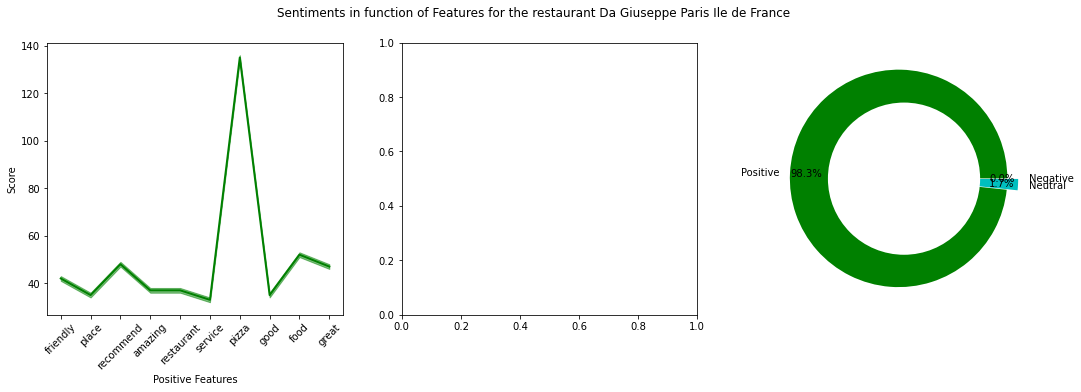

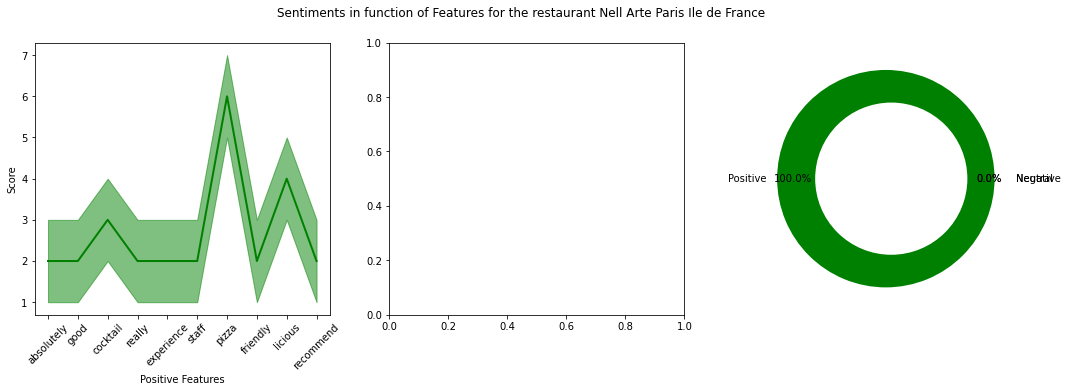

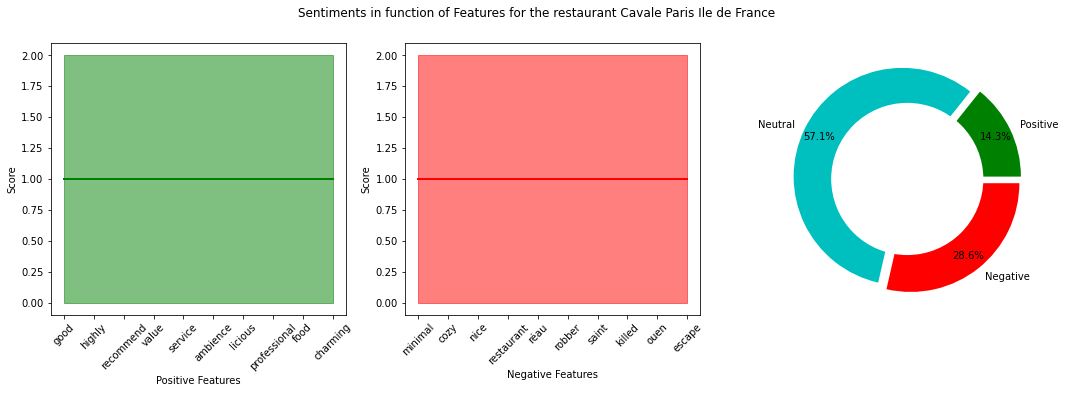

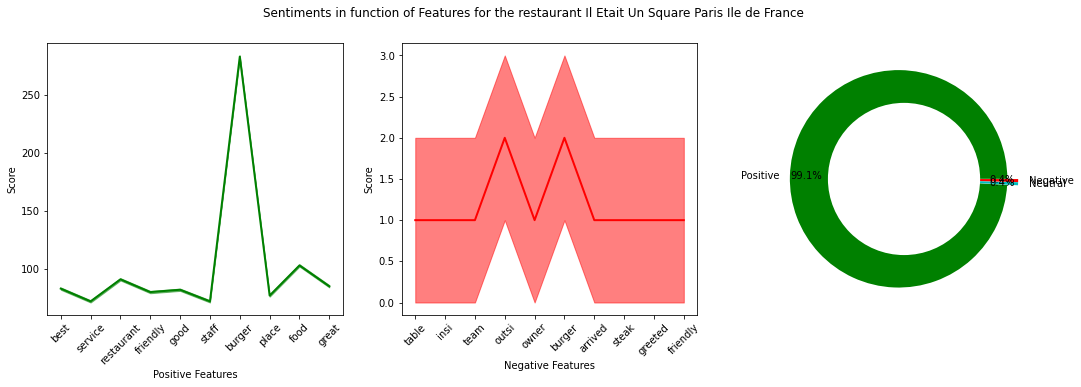

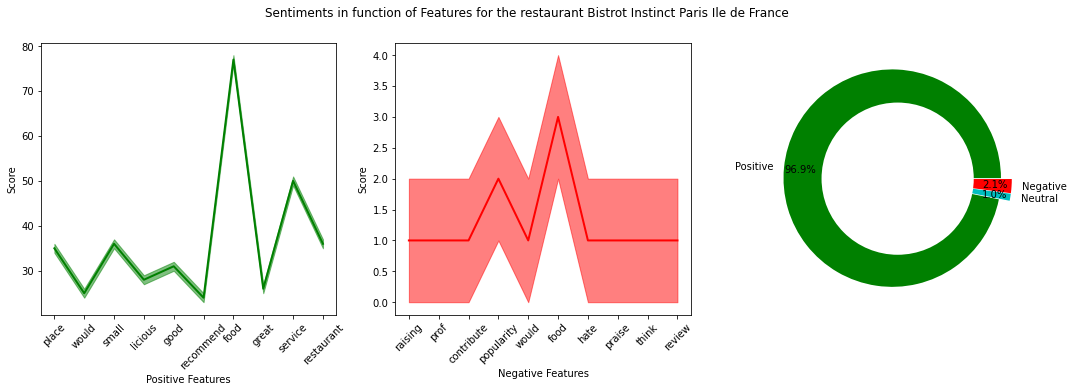

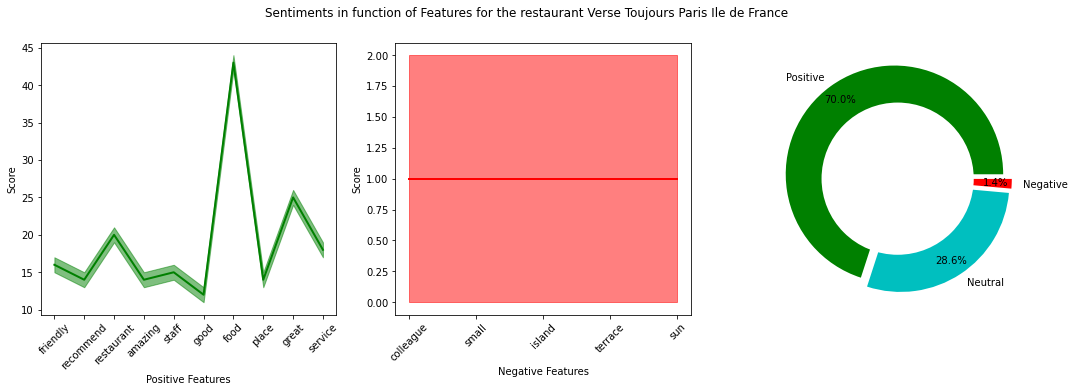

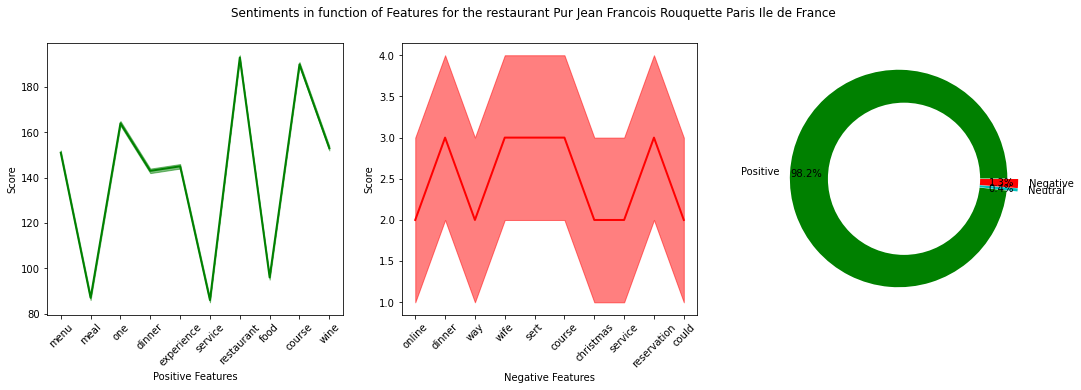

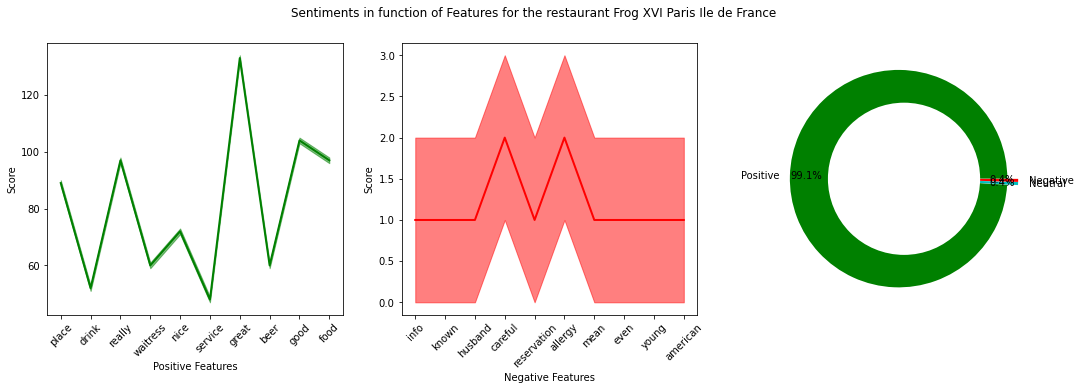

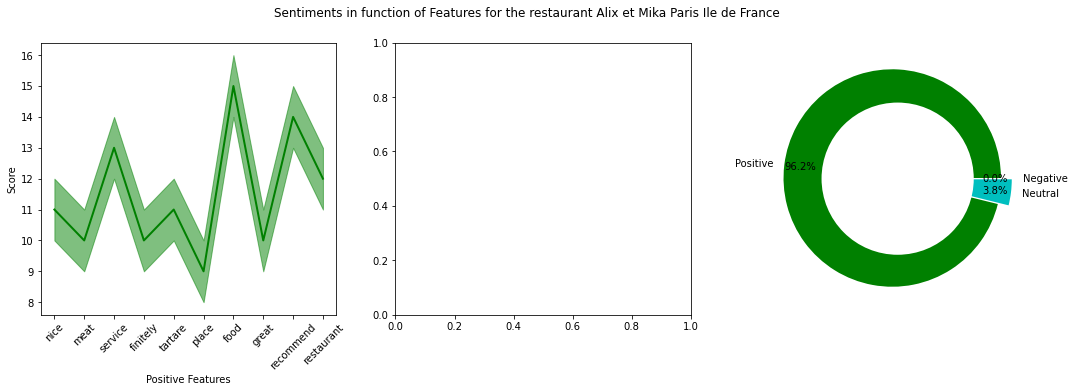

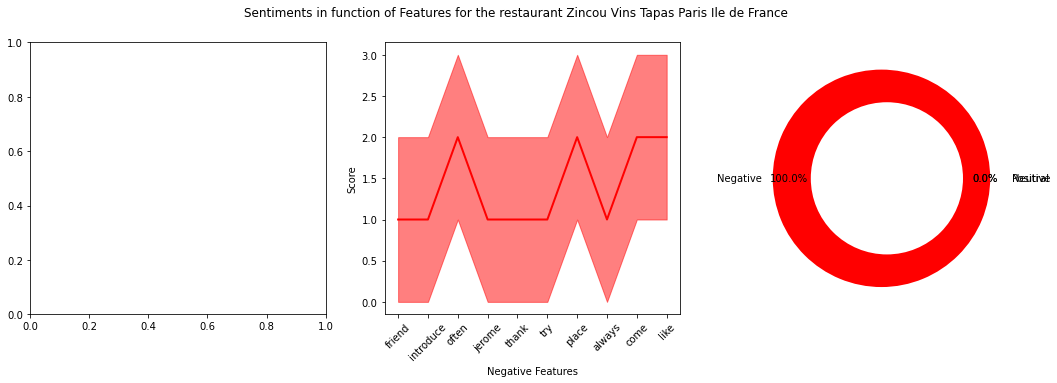

In [88]:
main('Paris')